# Testing the functions in torchgp.parameterizations.sqrtvar

In [1]:
%matplotlib notebook

import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR
from torchgp.symbolic import *
from torchgp.transforms import *
from torchgp.reparameterization import *
from torchgp.test_tools import *
from torchgp.kernels import *
from torchgp.parameterizations.sqrtvar import *
from torchgp.factorizations.randomized import *
from torchgp.natural_gradient import *
from torchgp.natural_gradient.optimizer import PatchAdam
import math
import networkx as nx
from matplotlib.pyplot import *
from itertools import chain
torch.set_default_dtype(torch.float32)

## Example 1a:

1. Fully observed
2. Gaussian likelihood
3. MC evaluation of likelihood, aka reparameterization gradients
4. 1D signal

In [27]:
#generate the data
x, yc, y = make_fake_herfd_fully_observed(10, 100, mean_snr=1.0)

<IPython.core.display.Javascript object>


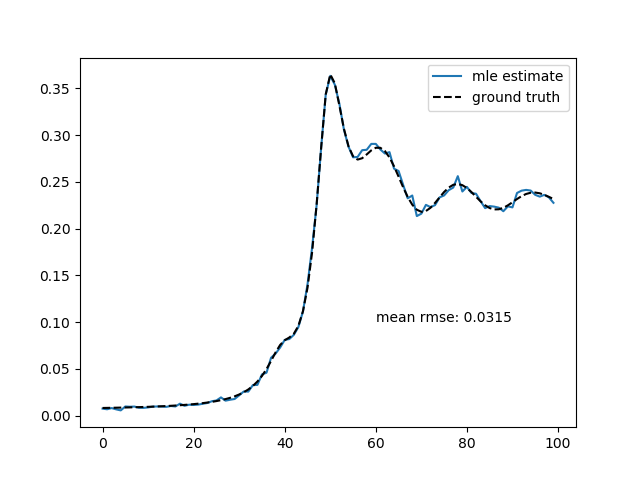

In [28]:
figure()
yd = np.random.poisson(y*0.15,size=(len(y),int(150e3/(0.15*len(y)))))
yhat = yd.mean(axis=1)
plot(yhat, label='mle estimate')
plot(y*0.15, 'k--', label='ground truth')
text(60, 0.1, f'mean rmse: {np.sqrt(np.sum((yhat-np.squeeze(y)*0.15)**2)):.4f}')
legend()

<IPython.core.display.Javascript object>


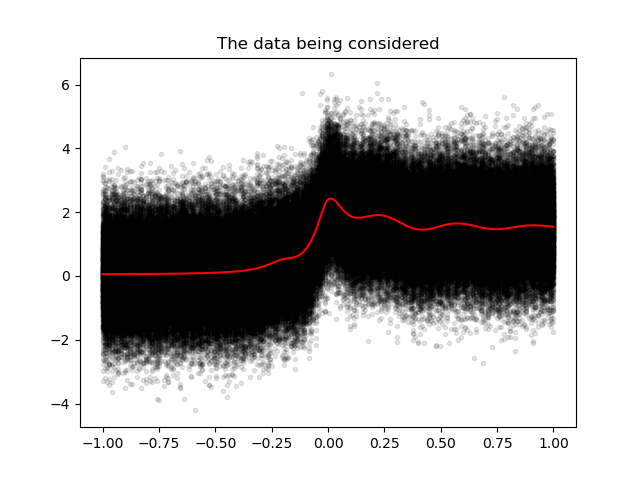

Text(0.5, 1.0, 'The data being considered')

In [3]:
figure()
plot(x,yc,'k.',alpha=0.1)
plot(x[:200],y,'r')
title('The data being considered')

In [6]:
class VFE_1D(torch.nn.Module):
    def __init__(self, U, Ntotal, Nmc = 10, std_lik_init = 5.0, lenscale_init = 0.2, dtype=torch.get_default_dtype()):
        super().__init__()
        self.dtype = dtype
        #define the input parameters
        #posterior mean vector
        m0 = MeanSymbol('m0')
        m = Vector('m')
        #posterior variance vector parameter
        L = Matrix('L')
        #axes that kernels are evaluated on
        u = Vector('u')
        f = Vector('f')
        #Kernels
        #these are the symbols that go into the graph
        K = Kernel('K')
        #observations, arranged Nx1
        y = Vector('y')
        Ntotal = Constant(Ntotal)
        #and finally the standard deviation of the likelihood
        std_lik = Scalar('std_lik')
        jitter = Scalar('jitter')
        Nmc = Constant(Nmc)
        #generally there are parameters which require positivity. I use this transform for them:
        self._makepos = SoftplusTransform()
        
        ### KL loss graph ###
        kl_loss = kl(K, u, m0, L, m, jitter)
        self._kl_loss_expr = kl_loss
        graph = expr2graph(Label(String("kl_loss"), kl_loss))
        self._kl_loss_fun = graph2ast(graph, compiled=True, debug=False)
        
        ### Predict to f-space ###
        mf = mean(K, u, f, m0, m, jitter)
        graph = expr2graph(Label(String("mean_pred"), mf))
        self._mean_pred = graph2ast(graph, compiled=True, debug=False)
        varf = var_fullspace_diag(K, f) - var_subspace_diag(K, u, f, jitter) + var_posterior_diag(K, u, f, L, jitter)
        graph = expr2graph(Label(String("var_pred"), varf))
        self._var_pred = graph2ast(graph, compiled=True, debug=False)
        
        
        ### Gaussian Likelihood in f-space ###
#         ve_loss = analytic_gaussian_likelihood(y, mf, varf, std_lik, Ntotal)
        ϵ = StdNormalSample(mf,Nmc)
        z = Sqrt(varf)*ϵ + mf
        ve_loss = gaussian_likelihood(y, z, std_lik, Ntotal)
        self._ve_loss_expr = ve_loss
        graph = expr2graph(Label(String("ve_loss"), ve_loss))
        self._ve_loss_fun = graph2ast(graph, compiled=True, debug=False)
        
        #form the total loss
        loss = -ve_loss + kl_loss
        graph = expr2graph(Label(String("loss"), loss))
        self._loss_fun = graph2ast(graph, compiled=True, debug=False)
        
        #symbolic functions needed for natural gradient:
        xi_to_source = sqrtvar_to_source(m,L)
        graph = expr2graph(Label(String("expr"), xi_to_source))
        self._xi_to_source = graph2ast(graph, compiled=True, debug=False)
        source_mean = Vector('source_mean')
        source_var = Matrix('source_var')
        source_to_xi = source_to_sqrtvar(source_mean, source_var, jitter)
        graph = expr2graph(Label(String("expr"), source_to_xi))
        self._source_to_xi = graph2ast(graph, compiled=True, debug=False)
        
        
        
        #the actual storage tensors go here:
        with torch.no_grad():
            self.hyper_params = torch.nn.ParameterDict({
                'std_lik': torch.nn.Parameter(self._makepos.inv(torch.tensor([[std_lik_init]],dtype=self.dtype))),
                'u': torch.nn.Parameter(torch.linspace(-1,1,U,dtype=self.dtype).unsqueeze(1)),
                #fixed parameters go here:
                'jitter': torch.nn.Parameter(torch.tensor(1e-4,dtype=self.dtype), requires_grad=False)
            })

            #modules containing parameters go here:
            self.stored_modules = torch.nn.ModuleDict({
                'K': ARDRBFKernel(lengthscale=torch.tensor([[lenscale_init]], dtype=self.dtype)),
                'm0': ConstantMean(torch.tensor(0., dtype=self.dtype), dtype=self.dtype),
                })
            #modules containing variational parameters go here:
            priorL = (self.stored_modules['K'](self.hyper_params['u'],self.hyper_params['u']) + 
                  torch.eye(U)*1e-4).cholesky()
            self.variational_gaussian = MVNGaussianSqrtVar(U, dtype=self.dtype)
            self.variational_gaussian.custom_L_init(priorL)
    def kl_loss(self):
        m, L = self.variational_gaussian.unpack()
        leaves = {
            **self.hyper_params,
            **self.stored_modules,
            'L': L,
            'm': m
        }
        result = self._kl_loss_fun(**leaves)
        return result.kl_loss
    def ve_loss(self, y, x):
        m, L = self.variational_gaussian.unpack()
        leaves = {
            'y': y,
            'f': x,
            **self.hyper_params,
            **self.stored_modules,
            'std_lik': self._makepos(self.hyper_params['std_lik']),
            'L': L,
            'm': m
        }
        result = self._ve_loss_fun(**leaves)
        return result.ve_loss
    def loss(self, y, x):
        m, L = self.variational_gaussian.unpack()
        leaves = {
            'y': y,
            'f': x,
            **self.hyper_params,
            **self.stored_modules,
            'std_lik': self._makepos(self.hyper_params['std_lik']),
            'L': L,
            'm': m
        }
        result = self._loss_fun(**leaves)
        return result.loss
    def predict_mean(self, x):
        m, L = self.variational_gaussian.unpack()
        leaves = {
            'f': x,
            **self.hyper_params,
            **self.stored_modules,
            'std_lik': self._makepos(self.hyper_params['std_lik']),
            'L': L,
            'm': m
        }
        result = self._mean_pred(**leaves)
        return result.mean_pred
    def predict_var(self, x):
        m, L = self.variational_gaussian.unpack()
        leaves = {
            'f': x,
            **self.hyper_params,
            **self.stored_modules,
            'std_lik': self._makepos(self.hyper_params['std_lik']),
            'L': L,
            'm': m
        }
        result = self._var_pred(**leaves)
        return result.var_pred
    def xi_to_source(self, xi):
        m, L = self.variational_gaussian.unpack(xi_packed=xi)
        leaves = {
                'f': x,
                **self.hyper_params,
                **self.stored_modules,
                'std_lik': self._makepos(self.hyper_params['std_lik']),
                'L': L,
                'm': m
            }
        m,S = self._xi_to_source(**leaves).expr
        return [m,S]
    def source_to_xi(self, m, S):
        leaves = {
                'f': x,
                **self.hyper_params,
                **self.stored_modules,
                'std_lik': self._makepos(self.hyper_params['std_lik']),
                'source_mean': m,
                'source_var': S
            }
        xi_unpacked = self._source_to_xi(**leaves).expr
        xi = self.variational_gaussian.pack(xi_unpacked)
        if torch.is_tensor(xi):
            return [xi]
        else:
            return list(xi)
        

In [7]:
m = VFE_1D(30,200*1000);
# m.hyper_params['u'].requires_grad = False
# m.stored_modules['K']._lengthscale_storage.requires_grad = False
# m.stored_modules['K']._amplitude_storage.requires_grad = False
# m.stored_modules['m0'].value.requires_grad = False
# m.cuda()
hyper_optimizer = torch.optim.Adam(chain(m.hyper_params.parameters(), m.stored_modules.parameters()),lr=1e-2)
optimizer = NaturalGradient(m.variational_gaussian.parameters(), lr=1)
schedule = LogSpaceScheduler(optimizer, -5, -1.0, 25)
bigbatcher = BigBatchScheduler(1000,5000,10,30)


epochs = 300
# scheduler = StepLR(optimizer,50,gamma=0.95)

data = TensorDataset(torch.from_numpy(x.astype('float32')), torch.from_numpy(yc.astype('float32')))
Logger = ScalarLogger(m, {'hyper_params.std_lik': m._makepos,
                          'stored_modules.K._lengthscale_storage': m._makepos,
                          'stored_modules.K._amplitude_storage': m._makepos},
                     extra_keys={'loss': lambda x: x,
                                'step_size': lambda x: x})

for i in range(epochs):
    bsize = bigbatcher.step()
    print(bsize)
    d = DataLoader(dataset=data, shuffle=True, batch_size=int(bsize))
    for (xb,yb) in d:
#         xbc, ybc = xb.cuda(), yb.cuda()
        optimizer.zero_grad()
        hyper_optimizer.zero_grad()
        loss = m.loss(yb, xb)
        loss.backward()
        hyper_optimizer.step()
        schedule.step()
        optimizer.step(m.xi_to_source, m.source_to_xi)
        Logger(extra_vals=[float(loss), float(optimizer.param_groups[0]['lr'])])
    print(Logger.report("epoch {:d}: ".format(i)))
        

Module path:  /Users/fdfuller/SLAC National Accelerator Laboratory/Fuller Group - Documents/Code/Frank/torchgp/notebooks/reparam/.compiled/90aa7d00bb838b54.py
Module path:  /Users/fdfuller/SLAC National Accelerator Laboratory/Fuller Group - Documents/Code/Frank/torchgp/notebooks/reparam/.compiled/078818802d755c5c.py
Module path:  /Users/fdfuller/SLAC National Accelerator Laboratory/Fuller Group - Documents/Code/Frank/torchgp/notebooks/reparam/.compiled/f31ae3cd60b738d7.py
Module path:  /Users/fdfuller/SLAC National Accelerator Laboratory/Fuller Group - Documents/Code/Frank/torchgp/notebooks/reparam/.compiled/afa4975ac105a590.py
Module path:  /Users/fdfuller/SLAC National Accelerator Laboratory/Fuller Group - Documents/Code/Frank/torchgp/notebooks/reparam/.compiled/13883727abfad2d0.py
Module path:  /Users/fdfuller/SLAC National Accelerator Laboratory/Fuller Group - Documents/Code/Frank/torchgp/notebooks/reparam/.compiled/1b3667f617961643.py
Module path:  /Users/fdfuller/SLAC National Ac

KeyboardInterrupt: 

In [8]:
m.cpu()

VFE_1D(
  (hyper_params): ParameterDict(
      (jitter): Parameter containing: [torch.FloatTensor of size ]
      (std_lik): Parameter containing: [torch.FloatTensor of size 1x1]
      (u): Parameter containing: [torch.FloatTensor of size 30x1]
  )
  (stored_modules): ModuleDict(
    (K): ARDRBFKernel(lengthscale=tensor([[0.0983]]), amplitude=0.31276655197143555)
    (m0): ConstantMean(value=1.0351722240447998)
  )
  (variational_gaussian): MVNGaussianSqrtVar(
    (packed_params): ModuleDict(
      (m): WrappedVector()
      (L): ConstrainedLowerTriangular()
    )
  )
)

In [9]:
figure()
μ = m.predict_mean(torch.linspace(-1,1,200).unsqueeze(1)).detach().numpy().squeeze()
σ = np.sqrt(m.predict_var(torch.linspace(-1,1,200).unsqueeze(1)).detach().numpy().squeeze())
plot(torch.linspace(-1,1,200).numpy(), μ, color='r',label='estimate')
fill_between(torch.linspace(-1,1,200).numpy(), μ + σ, μ - σ,color='k',alpha=0.5,label='+/- σ')
plot(x[:200],y,color='k',label='ground truth')
legend()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


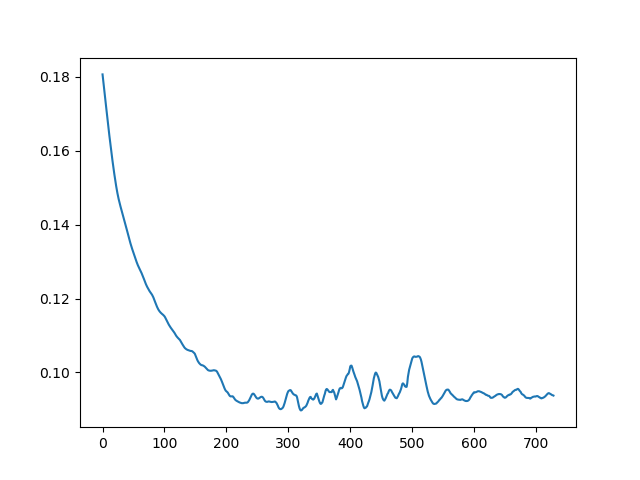

<IPython.core.display.Javascript object>


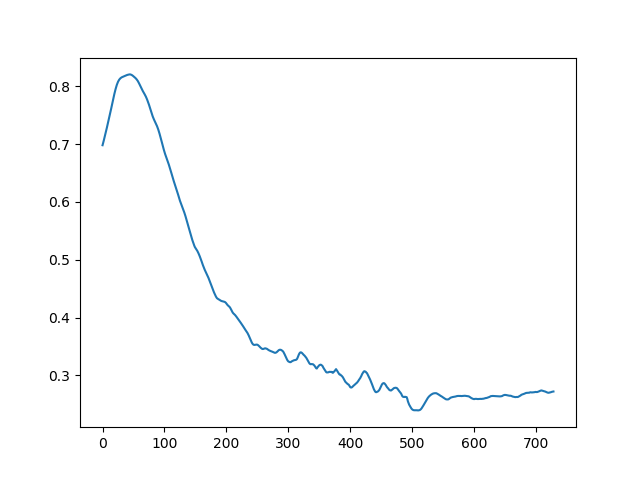

<IPython.core.display.Javascript object>


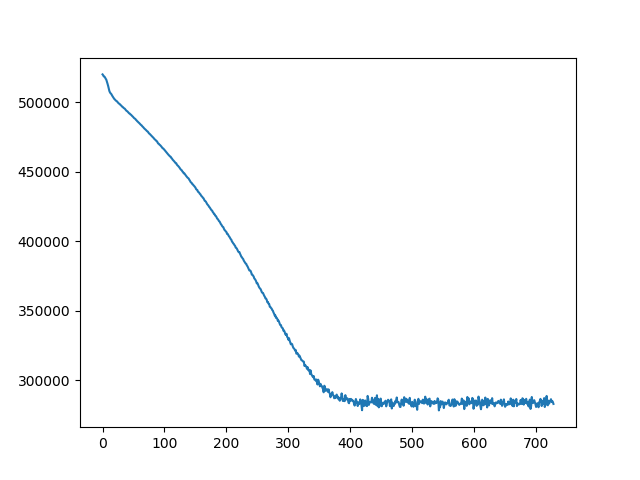

<IPython.core.display.Javascript object>


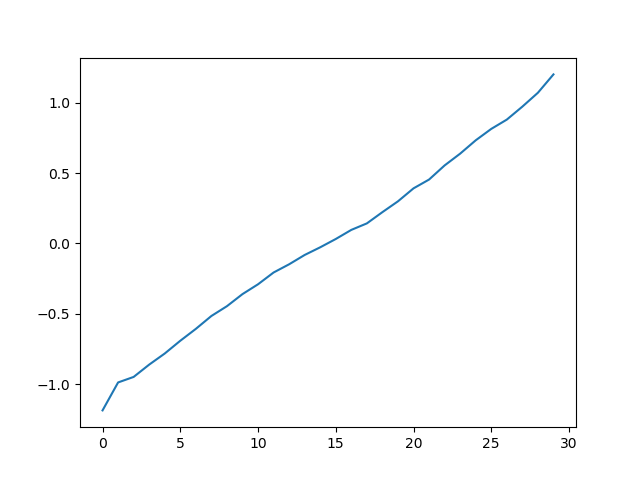

In [10]:
figure()
semilogy(Logger.val_dict['hyper_params.std_lik'])
figure()
plot(Logger.val_dict['stored_modules.K._lengthscale_storage'])
figure()
plot(Logger.val_dict['stored_modules.K._amplitude_storage'])
figure()
plot(Logger.val_dict['loss'])
figure()
plot(np.sort(m.hyper_params['u'].detach().numpy().squeeze()))

## Example 2a

1. 1D GPMM
2. Gaussian likelihood
3. MC evaluation of variational expectation, aka reparameterization gradients

In [3]:
X,  yc, y = make_fake_herfd_weighted(100000, 100)

In [4]:
figure()
plot(y)

<IPython.core.display.Javascript object>

In [5]:
class VFE_1D_GPMM(torch.nn.Module):
    def __init__(self, U0, F0, Ntotal, Nmc=10, std_lik_init = 0.5, lenscale_init = 0.05,
                 dtype=torch.get_default_dtype()):
        super().__init__()
        self.dtype = dtype
        m = Vector('m')
        mprior = MeanSymbol('mprior')
        L0 = Matrix('L0')
        u0 = Vector('u0')
        f0 = Vector('f0')
        K0 = Kernel('K0')
        y = Vector('y')
        X = Matrix('X')
        Ntotal = Constant(Ntotal)
        #and finally the standard deviation of the likelihood
        std_lik = Scalar('std_lik')
        jitter = Scalar('jitter')
        Nmc = Constant(Nmc)
        #generally there are parameters which require positivity. I use this transform for them:
        self._makepos = SoftplusTransform()
        
        ### KL loss graph ###
        kl_loss = kl(K0, u0, mprior, L0, m, jitter)
        self._kl_loss_expr = kl_loss
        graph = expr2graph(Label(String("kl_loss"), kl_loss))
        self._kl_loss_fun = graph2ast(graph, compiled=True, debug=False)
        
        ### Predict to weighted f-space ###
        mf = weighted_mean(K0, u0, f0, mprior, m, X, jitter)
        varf = weighted_var_fullspace_diag(K0, f0, X) - weighted_var_subspace_diag(K0, u0, f0, X, jitter) + \
                weighted_var_posterior_diag(K0, u0, f0, L0, X, jitter)
        
        ### Gaussian Likelihood in f-space ###
        ϵ = StdNormalSample(mf,Nmc)
        z = Sqrt(varf)*ϵ + mf
        ve_loss = gaussian_likelihood(y, z, std_lik, Ntotal)
#         ve_loss = analytic_gaussian_likelihood(y, mf, varf, std_lik, Ntotal)
        self._ve_loss_expr = ve_loss
        graph = expr2graph(Label(String("ve_loss"), ve_loss))
        self._ve_loss_fun = graph2ast(graph, compiled=True, debug=False)
        
        #form the total loss
        loss = -ve_loss + kl_loss
        graph = expr2graph(Label(String("loss"), loss))
        self._loss_fun = graph2ast(graph, compiled=True, debug=False)
        
        ### Predict to f-space ###
        mf = mean(K0, u0, f0, mprior, m, jitter)
        graph = expr2graph(Label(String("mean_pred"), mf))
        self._mean_pred = graph2ast(graph, compiled=True, debug=False)
        varf = var_fullspace_diag(K0, f0) - var_subspace_diag(K0, u0, f0, jitter) + \
                var_posterior_diag(K0, u0, f0, L0, jitter)
        graph = expr2graph(Label(String("var_pred"), varf))
        self._var_pred = graph2ast(graph, compiled=True, debug=False)
        
        #symbolic functions needed for natural gradient:
        xi_to_source = sqrtvar_to_source(m,L0)
        graph = expr2graph(Label(String("expr"), xi_to_source))
        self._xi_to_source = graph2ast(graph, compiled=True, debug=False)
        source_mean = Vector('source_mean')
        source_var = Matrix('source_var')
        source_to_xi = source_to_sqrtvar(source_mean, source_var)
        graph = expr2graph(Label(String("expr"), source_to_xi))
        self._source_to_xi = graph2ast(graph, compiled=True, debug=False)
        
        
        #the actual storage tensors go here:
        with torch.no_grad():
            self.hyper_params = torch.nn.ParameterDict({
                'std_lik': torch.nn.Parameter(self._makepos.inv(torch.tensor([[std_lik_init]],dtype=self.dtype))),
                'u0': torch.nn.Parameter(torch.linspace(-1,1,U0,dtype=self.dtype).unsqueeze(1)),
                #fixed parameters go here:
                'jitter': torch.nn.Parameter(torch.tensor(1e-4,dtype=self.dtype), requires_grad=False),
                'f0': torch.nn.Parameter(torch.linspace(-1,1,F0,dtype=self.dtype).unsqueeze(1), requires_grad=False),
            })

            #modules containing parameters go here:
            self.stored_modules = torch.nn.ModuleDict({
                'K0': ARDRBFKernel(lengthscale=torch.tensor([[lenscale_init]])),
                'mprior': ConstantMean(torch.tensor(0.))
                })
            #modules containing variational parameters go here:
            priorL = (self.stored_modules['K0'](self.hyper_params['u0'],self.hyper_params['u0']) + 
                  torch.eye(U0)*1e-4).cholesky()
            self.variational_gaussian = MVNGaussianSqrtVar(U0, dtype=self.dtype)
            self.variational_gaussian.custom_L_init(priorL)
    def kl_loss(self):
        m, L0 = self.variational_gaussian.unpack()
        leaves = {
            **self.hyper_params,
            **self.stored_modules,
            'L0': L0,
            'm': m
        }
        result = self._kl_loss_fun(**leaves)
        return result.kl_loss
    def ve_loss(self, y, X):
        m, L0 = self.variational_gaussian.unpack()
        leaves = {
            'y': y,
            'X': X,
            **self.hyper_params,
            **self.stored_modules,
            'L0': L0,
            'm': m,
            'std_lik': self._makepos(self.hyper_params['std_lik'])
        }
        result = self._ve_loss_fun(**leaves)
        return result.ve_loss
    def loss(self, y, X):
        m, L0 = self.variational_gaussian.unpack()
        leaves = {
            'y': y,
            'X': X,
            **self.hyper_params,
            **self.stored_modules,
            'L0': L0,
            'm': m,
            'std_lik': self._makepos(self.hyper_params['std_lik'])
        }
        result = self._loss_fun(**leaves)
        return result.loss
    def predict_mean(self):
        m, L0 = self.variational_gaussian.unpack()
        leaves = {
            **self.hyper_params,
            **self.stored_modules,
            'L0': L0,
            'm': m,
            'std_lik': self._makepos(self.hyper_params['std_lik'])
        }
        result = self._mean_pred(**leaves)
        return result.mean_pred
    def predict_var(self):
        m, L0 = self.variational_gaussian.unpack()
        leaves = {
            **self.hyper_params,
            **self.stored_modules,
            'L0': L0,
            'm': m,
            'std_lik': self._makepos(self.hyper_params['std_lik'])
        }
        result = self._var_pred(**leaves)
        return result.var_pred
    def xi_to_source(self, xi):
        m, L0 = self.variational_gaussian.unpack(xi_packed=xi)
        leaves = {
                'f': x,
                **self.hyper_params,
                **self.stored_modules,
                'std_lik': self._makepos(self.hyper_params['std_lik']),
                'L0': L0,
                'm': m
            }
        m,S = self._xi_to_source(**leaves).expr
        return [m,S]
    def source_to_xi(self, m, S):
        leaves = {
                'f': x,
                **self.hyper_params,
                **self.stored_modules,
                'std_lik': self._makepos(self.hyper_params['std_lik']),
                'source_mean': m,
                'source_var': S
            }
        xi_unpacked = self._source_to_xi(**leaves).expr
        xi = self.variational_gaussian.pack(xi_unpacked)
        if torch.is_tensor(xi):
            return [xi]
        else:
            return list(xi)

In [3]:
m = VFE_1D_GPMM(50,100,100000);
# m.hyper_params['u'].requires_grad = False
# m.stored_modules['K']._lengthscale_storage.requires_grad = False
# m.stored_modules['K']._amplitude_storage.requires_grad = False
# m.stored_modules['m0'].value.requires_grad = False
m.cuda()
hyper_optimizer = torch.optim.Adam(chain(m.hyper_params.parameters(), m.stored_modules.parameters()),lr=1e-2)
optimizer = NaturalGradient(m.variational_gaussian.parameters(), lr=1)
schedule = LogSpaceScheduler(optimizer, -5, -1.5, 25)
bigbatcher = BigBatchScheduler(10000,50000,10,5)


epochs = 1000
# scheduler = StepLR(optimizer,50,gamma=0.95)

data = TensorDataset(torch.from_numpy(X.astype('float32')), torch.from_numpy(yc.astype('float32')))
Logger = ScalarLogger(m, {'hyper_params.std_lik': m._makepos,
                          'stored_modules.K0._lengthscale_storage': m._makepos,
                          'stored_modules.K0._amplitude_storage': m._makepos,
                          'stored_modules.mprior.value': lambda x: x},
                     extra_keys={'loss': lambda x: x,
                                'step_size': lambda x: x})

for i in range(epochs):
    bsize = bigbatcher.step()
    print(bsize)
    d = DataLoader(dataset=data, shuffle=True, batch_size=int(bsize))
    for (xb,yb) in d:
        xbc, ybc = xb.cuda(), yb.cuda()
        optimizer.zero_grad()
        hyper_optimizer.zero_grad()
        loss = m.loss(ybc, xbc)
        loss.backward()
        hyper_optimizer.step()
        schedule.step()
        optimizer.step(m.xi_to_source, m.source_to_xi)
        Logger(extra_vals=[float(loss), float(optimizer.param_groups[0]['lr'])])
    print(Logger.report("epoch {:d}: ".format(i)))
        

Module path:  /reg/neh/home5/fdfuller/projects/GP/torchgp/notebooks/reparam/.compiled/fe6235a412301eab.py
Module path:  /reg/neh/home5/fdfuller/projects/GP/torchgp/notebooks/reparam/.compiled/c7eeea46ab178de0.py
Module path:  /reg/neh/home5/fdfuller/projects/GP/torchgp/notebooks/reparam/.compiled/80a2fb1f27d74c99.py
Module path:  /reg/neh/home5/fdfuller/projects/GP/torchgp/notebooks/reparam/.compiled/a9dd8fb166accca4.py
Module path:  /reg/neh/home5/fdfuller/projects/GP/torchgp/notebooks/reparam/.compiled/9e30380974ec36ab.py
Module path:  /reg/neh/home5/fdfuller/projects/GP/torchgp/notebooks/reparam/.compiled/97889bb19461452c.py


TypeError: source_to_sqrtvar() missing 1 required positional argument: 'jitter'

In [63]:
m.cpu()

VFE_1D_GPMM(
  (hyper_params): ParameterDict(
      (f0): Parameter containing: [torch.FloatTensor of size 100x1]
      (jitter): Parameter containing: [torch.FloatTensor of size ]
      (std_lik): Parameter containing: [torch.FloatTensor of size 1x1]
      (u0): Parameter containing: [torch.FloatTensor of size 50x1]
  )
  (stored_modules): ModuleDict(
    (K0): ARDRBFKernel(lengthscale=tensor([[0.0787]]), amplitude=0.32129815220832825)
    (mprior): ConstantMean(value=0.9595004916191101)
  )
  (variational_gaussian): MVNGaussianSqrtVar(
    (packed_params): ModuleDict(
      (m): WrappedVector()
      (L): ConstrainedLowerTriangular()
    )
  )
)

<IPython.core.display.Javascript object>


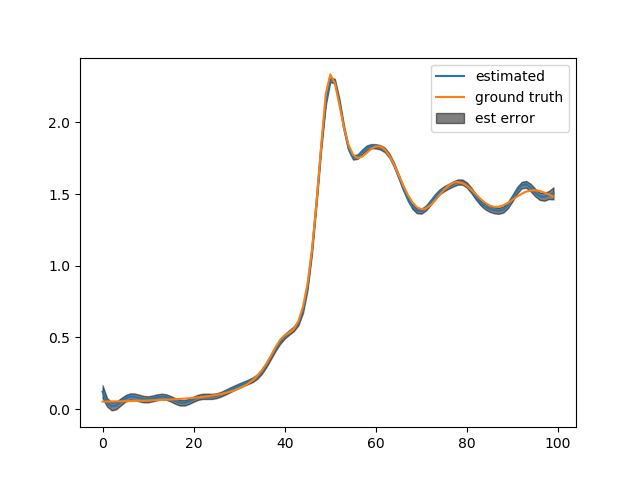

In [64]:
figure()
μ = m.predict_mean().detach().squeeze().numpy()
σ = m.predict_var().detach().sqrt().squeeze().numpy()
plot(μ, label='estimated')
fill_between(np.arange(100),μ+σ,μ-σ,color='k',alpha=0.5,label='est error')
plot(y,label='ground truth')
legend()

<IPython.core.display.Javascript object>


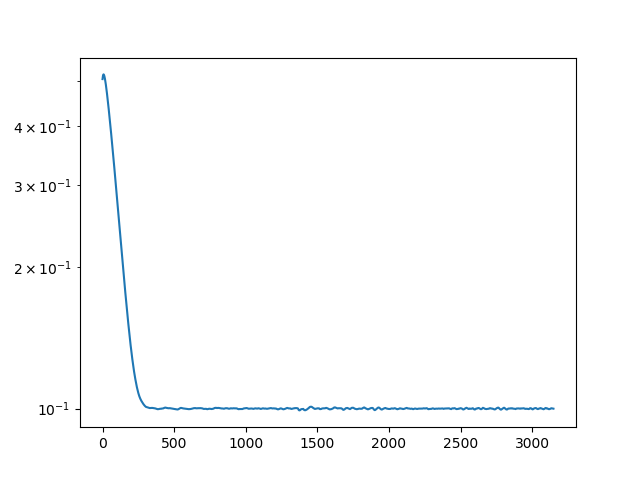

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


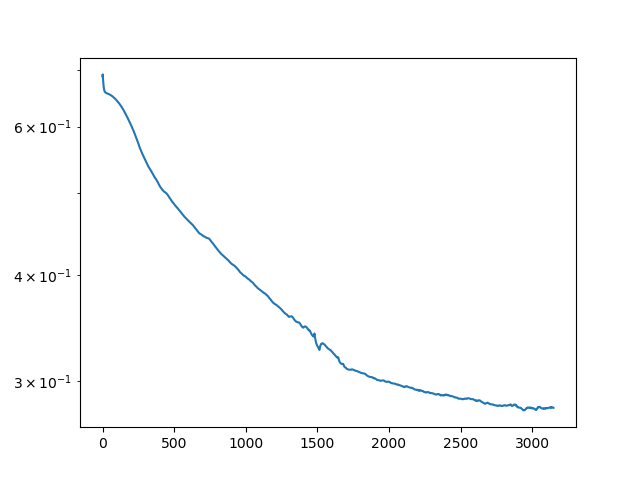

<IPython.core.display.Javascript object>


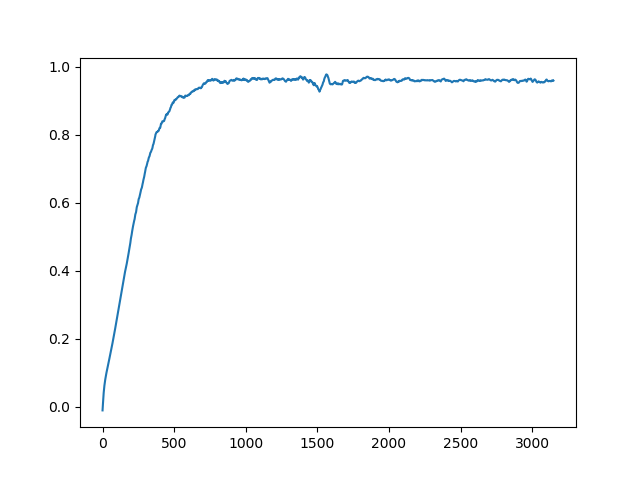

<IPython.core.display.Javascript object>


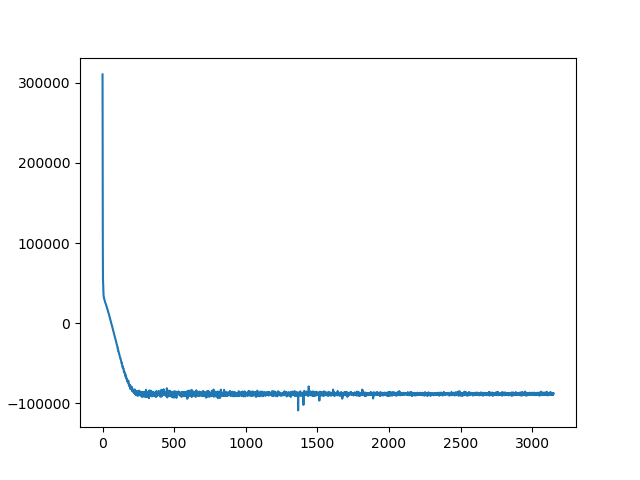

<IPython.core.display.Javascript object>


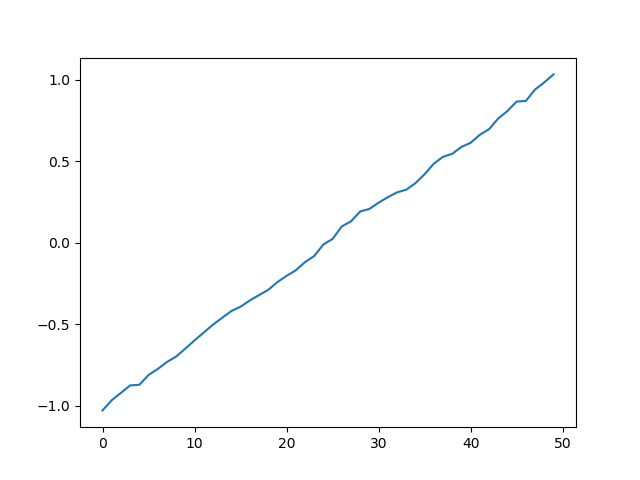

In [65]:
figure()
semilogy(Logger.val_dict['hyper_params.std_lik'])
figure()
semilogy(Logger.val_dict['stored_modules.K0._lengthscale_storage'])
figure()
semilogy(Logger.val_dict['stored_modules.K0._amplitude_storage'])
figure()
plot(Logger.val_dict['stored_modules.mprior.value'])
figure()
plot(Logger.val_dict['loss'])
figure()
plot(np.sort(m.hyper_params['u0'].detach().numpy().squeeze()))

## Example 3: GPMM with Poisson Noise & Poisson Likelihood

In [84]:
X,  yc, y = make_fake_herfd_weighted(int(1e6), 100, noise_type='Poisson', mean_snr=10.0)

In [85]:
yc.sum()

3161437.0

In [109]:
class VFE_1D_GPMM_Poisson_Streaming(torch.nn.Module):
    def __init__(self, U0, F0, Nmc = 400, max_root_rank = 100, std_lik_init = 0.5, lenscale_init = 0.1,
                 dtype=torch.get_default_dtype()):
        super().__init__()
        self.dtype = dtype
        m = Vector('m')
        m_old = Vector('m_old')
        mprior = MeanSymbol('mprior')
        L0 = Matrix('L0')
        L0_old = Matrix('L0_old')
        u0 = Vector('u0')
        u0_old = Vector('u0_old')
        f0 = Vector('f0')
        K0 = Kernel('K0')
        Lprior_old = Matrix('Lprior_old')
        mprior_old = Vector('mprior_old')
        y = Vector('y')
        X = Matrix('X')
        
#         Ntotal = Constant(Ntotal)
        #and finally the standard deviation of the likelihood
        std_lik = Scalar('std_lik')
        jitter = Scalar('jitter')
        Nmc = Constant(Nmc)
        max_root_rank = Constant(int(max_root_rank))
        #generally there are parameters which require positivity. I use this transform for them:
        self._makepos = SoftplusTransform()
        
        ### KL loss graph ###
        kl0 = kl(K0, u0, mprior, L0, m, jitter)
        kl1 = kl_to_oldposterior(K0, u0, u0_old, mprior, L0, L0_old, m, m_old, jitter)
        kl2 = kl_to_oldprior(K0, u0, u0_old, mprior, L0, Lprior_old, m, mprior_old, jitter)
        kl_loss = kl0 + kl1 - kl2
        kl_init = kl0
        self._kl_loss_expr = kl_loss
        graph = expr2graph(Label(String("kl_loss"), kl_loss))
        self._kl_loss_fun = graph2ast(graph, compiled=True, debug=False)

        
        ### Predict to f-space ###
        mf = mean(K0, u0, f0, mprior, m, jitter)
#         varf = var_fullspace(K0, f0) - var_subspace(K0, u0, f0, jitter) + \
#                 var_posterior(K0, u0, f0, L0, jitter)
#         varf_factorize = RRUL(varf, max_root_rank, jitter)
#         varf_U = Select(Constant(0), varf_factorize)
#         varf_L = Select(Constant(1), varf_factorize)
        
        
        varf_fitc = var_fullspace_diag(K0, f0) - var_subspace_diag(K0, u0, f0, jitter)
        varu_root = var_posterior_root(K0, u0, f0, L0, jitter)
        ϵu = StdNormalSample(u0,Nmc)
        ϵf = StdNormalSample(varf_fitc,Nmc)
        z = Sqrt(varf_fitc)*ϵf + varu_root @ ϵu + mf
        wz = X @ Softplus(z)
        M = Select(Constant(0),Shape(X))
        ve_loss = poisson_likelihood(y, wz, M)
        self._ve_loss_expr = ve_loss
        graph = expr2graph(Label(String("ve_loss"), ve_loss))
        self._ve_loss_fun = graph2ast(graph, compiled=True, debug=False)
        
        #form the total loss
        loss = -ve_loss + kl_loss
        graph = expr2graph(Label(String("loss"), loss))
        self._loss_fun = graph2ast(graph, compiled=True, debug=False)
        
        loss_init = -ve_loss + kl_init
        graph = expr2graph(Label(String("loss_init"), loss_init))
        self._loss_init_fun = graph2ast(graph, compiled=True, debug=False)
        
        ### Predict to f-space ###
        mf = mean(K0, u0, f0, mprior, m, jitter)
#         mf
        graph = expr2graph(Label(String("mean_pred"), mf))
        self._mean_pred = graph2ast(graph, compiled=True, debug=False)
        varf = var_fullspace_diag(K0, f0) - var_subspace_diag(K0, u0, f0, jitter) + \
                var_posterior_diag(K0, u0, f0, L0, jitter)
#         varf = ExtractDiagonal(L0 @ Transpose(L0))
        graph = expr2graph(Label(String("var_pred"), varf))
        self._var_pred = graph2ast(graph, compiled=True, debug=False)
        
        #symbolic functions needed for natural gradient:
        xi_to_source = sqrtvar_to_source(m,L0)
        graph = expr2graph(Label(String("expr"), xi_to_source))
        self._xi_to_source = graph2ast(graph, compiled=True, debug=False)
        source_mean = Vector('source_mean')
        source_var = Matrix('source_var')
        source_to_xi = source_to_sqrtvar(source_mean, source_var, jitter)
        graph = expr2graph(Label(String("expr"), source_to_xi))
        self._source_to_xi = graph2ast(graph, compiled=True, debug=False)
        
        #symbolic functions needed for streaming:
        prior_mean = EvaluateMean(mprior, u0)
        prior_cov = EvaluateKernelSymmetric(K0, u0)
        prior_cov = AddJitter(prior_cov,jitter)
        prior_L = CholeskyRoot(prior_cov)
        prior_mvn = TupleExpr(prior_mean, prior_L)
        graph = expr2graph(Label(String("prior_mvn"), prior_mvn))
        self._prior_mvn = graph2ast(graph, compiled=True, debug=False)
        
        
        #the actual storage tensors go here:
        with torch.no_grad():
            self.hyper_params = torch.nn.ParameterDict({
                'std_lik': torch.nn.Parameter(self._makepos.inv(torch.tensor([[std_lik_init]],dtype=self.dtype))),
                'u0': torch.nn.Parameter(torch.linspace(-1,1,U0,dtype=self.dtype).unsqueeze(1)),
                #fixed parameters go here:
                'jitter': torch.nn.Parameter(torch.tensor(1e-4,dtype=self.dtype), requires_grad=False),
                'f0': torch.nn.Parameter(torch.linspace(-1,1,F0,dtype=self.dtype).unsqueeze(1), requires_grad=False),
            })

            #modules containing parameters go here:
            self.stored_modules = torch.nn.ModuleDict({
                'K0': ARDRBFKernel(lengthscale=torch.tensor([[lenscale_init]]), amplitude=3.),
                'mprior': ConstantMean(torch.tensor(self._makepos.inv(torch.tensor(3., dtype=self.dtype)).item(), dtype=self.dtype))
                })
            #modules containing variational parameters go here:
            self.variational_gaussian = MVNGaussianSqrtVar(U0, dtype=self.dtype)
            prior_mean, priorL = self.prior_mvn()
            packed_prior_mean, packed_priorL = self.variational_gaussian.pack([prior_mean, priorL])
            
            #Buffers for streaming
            self.register_buffer('L0_old', packed_priorL.clone().detach())
            self.register_buffer('m_old', packed_prior_mean.clone().detach())
            self.register_buffer('u0_old', self.hyper_params['u0'].clone().detach())
            self.register_buffer('Lprior_old', priorL.clone().detach())
            self.register_buffer('mprior_old', prior_mean.clone().detach())
#             self.variational_gaussian.custom_L_init(torch.eye(80))
            
    def update_buffers(self):
        self.L0_old.copy_(self.variational_gaussian.packed_params['L'].packed.data)
        self.m_old.copy_(self.variational_gaussian.packed_params['m'].storage.data)
        self.u0_old.copy_(self.hyper_params['u0'].data)
        prior_mean, priorL = self.prior_mvn()
        self.Lprior_old.copy_(priorL.data)
        self.mprior_old.copy_(prior_mean.data)
    def unpack_buffers(self):
        m_old, L0_old = m.variational_gaussian.unpack([self.m_old, self.L0_old])
        leaves = {
            'L0_old': L0_old,
            'm_old': m_old,
            'u0_old': self.u0_old,
            'Lprior_old': self.Lprior_old,
            'mprior_old': self.mprior_old
        }
        return leaves
    def prior_mvn(self):
        leaves = {
            **self.hyper_params,
            **self.stored_modules,
        }
        result = self._prior_mvn(**leaves)
        return result.prior_mvn
    def kl_loss(self):
        m, L0 = self.variational_gaussian.unpack()
        leaves = {
            **self.hyper_params,
            **self.stored_modules,
            **self.unpack_buffers(),
            'L0': L0,
            'm': m
        }
        result = self._kl_loss_fun(**leaves)
        return result.kl_loss
    def ve_loss(self, y, X):
        m, L0 = self.variational_gaussian.unpack()
        leaves = {
            'y': y,
            'X': X,
            **self.hyper_params,
            **self.stored_modules,
            **self.unpack_buffers(),
            'L0': L0,
            'm': m,
            'std_lik': self._makepos(self.hyper_params['std_lik'])
        }
        result = self._ve_loss_fun(**leaves)
        return result.ve_loss
    def loss(self, y, X):
        m, L0 = self.variational_gaussian.unpack()
        leaves = {
            'y': y,
            'X': X,
            **self.hyper_params,
            **self.stored_modules,
            **self.unpack_buffers(),
            'L0': L0,
            'm': m,
            'std_lik': self._makepos(self.hyper_params['std_lik'])
        }
        result = self._loss_fun(**leaves)
        return result.loss
    def loss_init(self, y, X):
        m, L0 = self.variational_gaussian.unpack()
        leaves = {
            'y': y,
            'X': X,
            **self.hyper_params,
            **self.stored_modules,
            **self.unpack_buffers(),
            'L0': L0,
            'm': m,
            'std_lik': self._makepos(self.hyper_params['std_lik'])
        }
        result = self._loss_init_fun(**leaves)
        return result.loss_init
    def predict_mean(self):
        m, L0 = self.variational_gaussian.unpack()
        leaves = {
            **self.hyper_params,
            **self.stored_modules,
            **self.unpack_buffers(),
            'L0': L0,
            'm': m,
            'std_lik': self._makepos(self.hyper_params['std_lik'])
        }
        result = self._mean_pred(**leaves)
        return result.mean_pred
    def predict_var(self):
        m, L0 = self.variational_gaussian.unpack()
        leaves = {
            **self.hyper_params,
            **self.stored_modules,
            **self.unpack_buffers(),
            'L0': L0,
            'm': m,
            'std_lik': self._makepos(self.hyper_params['std_lik'])
        }
        result = self._var_pred(**leaves)
        return result.var_pred
    def xi_to_source(self, xi):
        m, L0 = self.variational_gaussian.unpack(xi_packed=xi)
        leaves = {
                **self.hyper_params,
                **self.stored_modules,
                **self.unpack_buffers(),
                'std_lik': self._makepos(self.hyper_params['std_lik']),
                'L0': L0,
                'm': m
            }
        m,S = self._xi_to_source(**leaves).expr
        return [m,S]
    def source_to_xi(self, m, S):
        leaves = {
                **self.hyper_params,
                **self.stored_modules,
                **self.unpack_buffers(),
                'std_lik': self._makepos(self.hyper_params['std_lik']),
                'source_mean': m,
                'source_var': S
            }
        xi_unpacked = self._source_to_xi(**leaves).expr
        xi = self.variational_gaussian.pack(xi_unpacked)
        if torch.is_tensor(xi):
            return [xi]
        else:
            return list(xi)

In [87]:
class VFE_1D_GPMM_Poisson(torch.nn.Module):
    def __init__(self, U0, F0, Ntotal, Nmc=1, max_root_rank = 100, std_lik_init = 0.5, lenscale_init = 0.1,
                 dtype=torch.get_default_dtype()):
        super().__init__()
        self.dtype = dtype
        m = Vector('m')
        mprior = MeanSymbol('mprior')
        L0 = Matrix('L0')
        u0 = Vector('u0')
        f0 = Vector('f0')
        K0 = Kernel('K0')
        y = Vector('y')
        X = Matrix('X')
        Ntotal = Constant(Ntotal)
        #and finally the standard deviation of the likelihood
        std_lik = Scalar('std_lik')
        jitter = Scalar('jitter')
        Nmc = Constant(Nmc)
        max_root_rank = Constant(int(max_root_rank))
        #generally there are parameters which require positivity. I use this transform for them:
        self._makepos = SoftplusTransform()
        
        ### KL loss graph ###
        kl_loss = kl(K0, u0, mprior, L0, m, jitter)
        self._kl_loss_expr = kl_loss
        graph = expr2graph(Label(String("kl_loss"), kl_loss))
        self._kl_loss_fun = graph2ast(graph, compiled=True, debug=False)
        
        ### Predict to f-space ###
        mf = mean(K0, u0, f0, mprior, m, jitter)
#         mf = m
#         wmf = weighted_mean(K0, u0, f0, mprior, m, X, jitter)
#         r0 = CholeskyRoot(AddJitter(var_fullspace(K0, f0),jitter))
#         r1 = var_subspace_root(K0, u0, f0, jitter)
#         r2 = var_posterior_root(K0, u0, f0, L0, jitter)
#         varf = var_fullspace(K0, f0) - var_subspace(K0, u0, f0, jitter) + \
#                 var_posterior(K0, u0, f0, L0, jitter)
#         varf_factorize = RRUL(varf, max_root_rank, jitter)
#         varf_U = Select(Constant(0), varf_factorize)
#         varf_L = Select(Constant(1), varf_factorize)
        varf_fitc = var_fullspace_diag(K0, f0) - var_subspace_diag(K0, u0, f0, jitter)
        varu_root = var_posterior_root(K0, u0, f0, L0, jitter)
#         varf_L = L0
#         varf_root = CholeskyRoot(AddJitter(varf,jitter))

#         w_varf = weighted_var_fullspace_diag(K0,f0, X) - \
#                 weighted_var_subspace_diag(K0, u0, f0, X, jitter) + \
#                 weighted_var_posterior_diag(K0, u0, f0, L0, X, jitter)
#         varf_diag = var_fullspace_diag(K0,f0) - \
#                 var_subspace_diag(K0, u0, f0, jitter) + \
#                 var_posterior_diag(K0, u0, f0, L0, jitter)
        
        ### Gaussian Likelihood in f-space ###
#         ϵ = StdNormalSample(varf_diag,Nmc)
        ϵu = StdNormalSample(u0,Nmc)
        ϵf = StdNormalSample(varf_fitc,Nmc)
#         ϵ = StdNormalSample(varf_root,Nmc)
#         z = (varf_root @ ϵ) + mf
#         z = (varf_U @ (varf_L @ ϵ)) + mf
        z = Sqrt(varf_fitc)*ϵf + varu_root @ ϵu + mf
#         z = (varf_L @ ϵ) + mf
#         z = (Sqrt(varf_diag) * ϵ) + mf
#         wz = PartialSum(X * Transpose(Softplus(z)), Constant(1))
        wz = X @ Softplus(z)
#         ve_loss = gaussian_likelihood(y, wz, std_lik, Ntotal)
        ve_loss = poisson_likelihood(y, wz, Ntotal)
#         ve_loss = analytic_gaussian_likelihood(y, mf, varf, std_lik, Ntotal)
        self._ve_loss_expr = ve_loss
        graph = expr2graph(Label(String("ve_loss"), ve_loss))
        self._ve_loss_fun = graph2ast(graph, compiled=True, debug=False)
        
        #form the total loss
        loss = -ve_loss + kl_loss
        graph = expr2graph(Label(String("loss"), loss))
        self._loss_fun = graph2ast(graph, compiled=True, debug=False)
        
        ### Predict to f-space ###
        mf = mean(K0, u0, f0, mprior, m, jitter)
#         mf
        graph = expr2graph(Label(String("mean_pred"), mf))
        self._mean_pred = graph2ast(graph, compiled=True, debug=False)
        varf = var_fullspace_diag(K0, f0) - var_subspace_diag(K0, u0, f0, jitter) + \
                var_posterior_diag(K0, u0, f0, L0, jitter)
#         varf = ExtractDiagonal(L0 @ Transpose(L0))
        graph = expr2graph(Label(String("var_pred"), varf))
        self._var_pred = graph2ast(graph, compiled=True, debug=False)
        
        #symbolic functions needed for natural gradient:
        xi_to_source = sqrtvar_to_source(m,L0)
        graph = expr2graph(Label(String("expr"), xi_to_source))
        self._xi_to_source = graph2ast(graph, compiled=True, debug=False)
        source_mean = Vector('source_mean')
        source_var = Matrix('source_var')
        source_to_xi = source_to_sqrtvar(source_mean, source_var, jitter)
        graph = expr2graph(Label(String("expr"), source_to_xi))
        self._source_to_xi = graph2ast(graph, compiled=True, debug=False)
        
        
        #the actual storage tensors go here:
        with torch.no_grad():
            self.hyper_params = torch.nn.ParameterDict({
                'std_lik': torch.nn.Parameter(self._makepos.inv(torch.tensor([[std_lik_init]],dtype=self.dtype))),
                'u0': torch.nn.Parameter(torch.linspace(-1,1,U0,dtype=self.dtype).unsqueeze(1)),
                #fixed parameters go here:
                'jitter': torch.nn.Parameter(torch.tensor(1e-4,dtype=self.dtype), requires_grad=False),
                'f0': torch.nn.Parameter(torch.linspace(-1,1,F0,dtype=self.dtype).unsqueeze(1), requires_grad=False),
            })

            #modules containing parameters go here:
            self.stored_modules = torch.nn.ModuleDict({
                'K0': ARDRBFKernel(lengthscale=torch.tensor([[lenscale_init]]), amplitude=0.15),
                'mprior': ConstantMean(torch.tensor(self._makepos.inv(torch.tensor(0.15, dtype=self.dtype)).item(), dtype=self.dtype))
                })
            #modules containing variational parameters go here:
            priorL = (self.stored_modules['K0'](self.hyper_params['u0'],self.hyper_params['u0']) + 
                  torch.eye(U0)*1e-4).cholesky()
            self.variational_gaussian = MVNGaussianSqrtVar(U0, dtype=self.dtype)
            self.variational_gaussian.custom_L_init(priorL)
    def kl_loss(self):
        m, L0 = self.variational_gaussian.unpack()
        leaves = {
            **self.hyper_params,
            **self.stored_modules,
            'L0': L0,
            'm': m
        }
        result = self._kl_loss_fun(**leaves)
        return result.kl_loss
    def ve_loss(self, y, X):
        m, L0 = self.variational_gaussian.unpack()
        leaves = {
            'y': y,
            'X': X,
            **self.hyper_params,
            **self.stored_modules,
            'L0': L0,
            'm': m,
            'std_lik': self._makepos(self.hyper_params['std_lik'])
        }
        result = self._ve_loss_fun(**leaves)
        return result.ve_loss
    def loss(self, y, X):
        m, L0 = self.variational_gaussian.unpack()
        leaves = {
            'y': y,
            'X': X,
            **self.hyper_params,
            **self.stored_modules,
            'L0': L0,
            'm': m,
            'std_lik': self._makepos(self.hyper_params['std_lik'])
        }
        result = self._loss_fun(**leaves)
        return result.loss
    def predict_mean(self):
        m, L0 = self.variational_gaussian.unpack()
        leaves = {
            **self.hyper_params,
            **self.stored_modules,
            'L0': L0,
            'm': m,
            'std_lik': self._makepos(self.hyper_params['std_lik'])
        }
        result = self._mean_pred(**leaves)
        return result.mean_pred
    def predict_var(self):
        m, L0 = self.variational_gaussian.unpack()
        leaves = {
            **self.hyper_params,
            **self.stored_modules,
            'L0': L0,
            'm': m,
            'std_lik': self._makepos(self.hyper_params['std_lik'])
        }
        result = self._var_pred(**leaves)
        return result.var_pred
    def xi_to_source(self, xi):
        m, L0 = self.variational_gaussian.unpack(xi_packed=xi)
        leaves = {
                **self.hyper_params,
                **self.stored_modules,
                'std_lik': self._makepos(self.hyper_params['std_lik']),
                'L0': L0,
                'm': m
            }
        m,S = self._xi_to_source(**leaves).expr
        return [m,S]
    def source_to_xi(self, m, S):
        leaves = {
                **self.hyper_params,
                **self.stored_modules,
                'std_lik': self._makepos(self.hyper_params['std_lik']),
                'source_mean': m,
                'source_var': S
            }
        xi_unpacked = self._source_to_xi(**leaves).expr
        xi = self.variational_gaussian.pack(xi_unpacked)
        if torch.is_tensor(xi):
            return [xi]
        else:
            return list(xi)

In [6]:
m = VFE_1D_GPMM_Poisson_Streaming(80,100,1000000)
# m.hyper_params['u'].requires_grad = False
# m.stored_modules['K']._lengthscale_storage.requires_grad = False
# m.stored_modules['K']._amplitude_storage.requires_grad = False
# m.stored_modules['m0'].value.requires_grad = False
# m.cuda()
# optimizer = NaturalGradient(m.variational_gaussian.parameters(), lr=1)
optimizer = FisherNormLimitedNaturalGradient(m.variational_gaussian.parameters(), lr=1.0, norm_limit=0.3)
# schedule = LogSpaceScheduler(optimizer, -1, 0, 10)
# bigbatcher = BigBatchScheduler(1000,5000,10,30)


epochs = 10000

for i in range(epochs):
    optimizer.zero_grad()
    loss = m.kl_loss()
    loss.backward()
#     schedule.step()
    optimizer.step(m.xi_to_source, m.source_to_xi, batch_fraction=1.)
    print(f"{i}: loss = {loss.item()}, stepsize = {optimizer.param_groups[0]['lr']}")
    if loss<1e-5:
        break
        

Module path:  /home/fdfuller/work/torchgp/notebooks/reparam/.compiled/1d7745eb37370efb.py
Module path:  /home/fdfuller/work/torchgp/notebooks/reparam/.compiled/8ec13b8788be836f.py
Module path:  /home/fdfuller/work/torchgp/notebooks/reparam/.compiled/ddfa0b7752d93118.py
Module path:  /home/fdfuller/work/torchgp/notebooks/reparam/.compiled/f0f345003abac697.py
Module path:  /home/fdfuller/work/torchgp/notebooks/reparam/.compiled/a9dd8fb166accca4.py
Module path:  /home/fdfuller/work/torchgp/notebooks/reparam/.compiled/9e30380974ec36ab.py
Module path:  /home/fdfuller/work/torchgp/notebooks/reparam/.compiled/97889bb19461452c.py
Module path:  /home/fdfuller/work/torchgp/notebooks/reparam/.compiled/47f4895a528044d3.py
Module path:  /home/fdfuller/work/torchgp/notebooks/reparam/.compiled/1cfd4e9232223729.py
0: loss = 235169.3125, stepsize = 1.0
1: loss = 221164.953125, stepsize = 1.0
2: loss = 208008.96875, stepsize = 1.0
3: loss = 195649.046875, stepsize = 1.0
4: loss = 184036.21875, stepsize 

177: loss = 4.538970947265625, stepsize = 1.0
178: loss = 3.813812255859375, stepsize = 1.0
179: loss = 3.141845703125, stepsize = 1.0
180: loss = 2.52435302734375, stepsize = 1.0
181: loss = 1.965850830078125, stepsize = 1.0
182: loss = 1.469146728515625, stepsize = 1.0
183: loss = 1.038604736328125, stepsize = 1.0
184: loss = 0.677398681640625, stepsize = 1.0
185: loss = 0.389190673828125, stepsize = 1.0
186: loss = 0.177825927734375, stepsize = 1.0
187: loss = 0.046844482421875, stepsize = 1.0
188: loss = 9.1552734375e-05, stepsize = 1.0
189: loss = 0.0, stepsize = 1.0


In [18]:
0.3/2278305792.0

1.3167679292806714e-10

In [10]:
figure()
plot(m.variational_gaussian.unpack()[0].detach().numpy())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


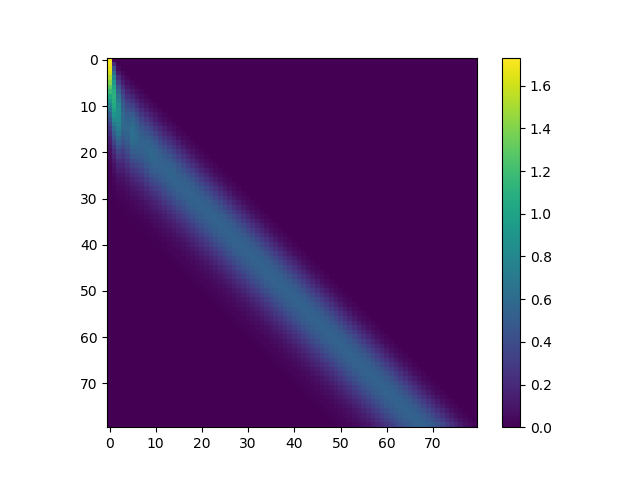

In [11]:
figure()
L = m.variational_gaussian.unpack()[1].detach().numpy()
imshow(L)
colorbar()

<IPython.core.display.Javascript object>


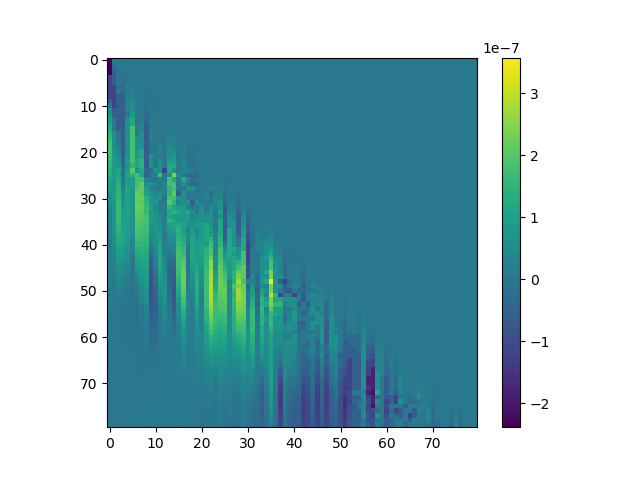

In [12]:
figure()
imshow(m.unpack_buffers()['L0_old'].numpy() - L)
colorbar()

In [120]:
m = VFE_1D_GPMM_Poisson_Streaming(80,100,Nmc=400);
# m = VFE_1D_GPMM_Poisson(80,100,X.shape[0],Nmc=400)
m.hyper_params['u0'].requires_grad = True
# m.stored_modules['K0']._lengthscale_storage.requires_grad = False
# m.stored_modules['K0']._amplitude_storage.requires_grad = False
# m.stored_modules['mprior'].value.requires_grad = False
m.cuda()
hyper_optimizer = torch.optim.Adam(chain(m.hyper_params.parameters(), m.stored_modules.parameters()),lr=1e-3)
optimizer = FisherNormLimitedNaturalGradient(m.variational_gaussian.parameters(), lr=1.0, norm_limit=0.3)
bigbatcher = BigBatchScheduler(5000,100000,50,10)



data = TensorDataset(torch.from_numpy(X.astype('float32')), torch.from_numpy(yc.astype('float32')))
Logger = ScalarLogger(m, {'stored_modules.K0._lengthscale_storage': m._makepos,
                          'stored_modules.K0._amplitude_storage': m._makepos,
                          'stored_modules.mprior.value': lambda x: x},
                     extra_keys={'loss': lambda x: x,
                                'step_size': lambda x: x})
means = []
stds = []
c = 0
e = 0
steps = 1e5
start_ind = 0
burn_in = 2000
segment_epochs = 1000
segment_length = int(1e4)

Module path:  /home/fdfuller/work/torchgp/notebooks/reparam/.compiled/1d7745eb37370efb.py
Module path:  /home/fdfuller/work/torchgp/notebooks/reparam/.compiled/c98fb0f10ec1b9b2.py
Module path:  /home/fdfuller/work/torchgp/notebooks/reparam/.compiled/549157e637e707df.py
Module path:  /home/fdfuller/work/torchgp/notebooks/reparam/.compiled/c659fa34d5fdb030.py
Module path:  /home/fdfuller/work/torchgp/notebooks/reparam/.compiled/a9dd8fb166accca4.py
Module path:  /home/fdfuller/work/torchgp/notebooks/reparam/.compiled/9e30380974ec36ab.py
Module path:  /home/fdfuller/work/torchgp/notebooks/reparam/.compiled/97889bb19461452c.py
Module path:  /home/fdfuller/work/torchgp/notebooks/reparam/.compiled/47f4895a528044d3.py
Module path:  /home/fdfuller/work/torchgp/notebooks/reparam/.compiled/1cfd4e9232223729.py


In [121]:
m.cuda()
while c < X.shape[0]//segment_length:
#     bigbatcher = BigBatchScheduler(segment_length//10,segment_length,segment_epochs//10,10)
    data = TensorDataset(torch.from_numpy(X[start_ind:segment_length+start_ind,:].astype('float32')),
                         torch.from_numpy(yc[start_ind:segment_length+start_ind,:].astype('float32')))
    for k in range(segment_epochs):
#         bsize = bigbatcher.step()
        bsize = segment_length
        d = DataLoader(dataset=data, shuffle=True, batch_size=bsize)
        for (xb,yb) in d:
            xbc, ybc = xb.cuda(), yb.cuda()
            optimizer.zero_grad()
            hyper_optimizer.zero_grad()
            if c==0:
                loss = m.loss_init(ybc, xbc)
            else:
                loss = m.loss(ybc, xbc)
            loss.backward()
            lr = optimizer.step(m.xi_to_source, m.source_to_xi)
            hyper_optimizer.step()
            Logger(extra_vals=[float(loss), float(lr)])            
    print(Logger.report(f"segment {c}, epoch {k}: "))
    with torch.no_grad():
        means.append(m.predict_mean().detach().squeeze())
        stds.append(m.predict_var().detach().sqrt().squeeze())
    c += 1
    m.update_buffers()
    start_ind += segment_length

segment 0, epoch 999: stored_modules.K0._lengthscale_storage: 0.0948154, stored_modules.K0._amplitude_storage: 3.0612, stored_modules.mprior.value: 2.81421, loss: 18956.7, step_size: 0.219047, 
segment 1, epoch 999: stored_modules.K0._lengthscale_storage: 0.0948649, stored_modules.K0._amplitude_storage: 3.06752, stored_modules.mprior.value: 2.8132, loss: 18890.6, step_size: 0.361155, 
segment 2, epoch 999: stored_modules.K0._lengthscale_storage: 0.094887, stored_modules.K0._amplitude_storage: 3.08218, stored_modules.mprior.value: 2.85397, loss: 18967.6, step_size: 0.400534, 
segment 3, epoch 999: stored_modules.K0._lengthscale_storage: 0.0949148, stored_modules.K0._amplitude_storage: 3.11114, stored_modules.mprior.value: 2.83246, loss: 19178.2, step_size: 0.318341, 
segment 4, epoch 999: stored_modules.K0._lengthscale_storage: 0.0950151, stored_modules.K0._amplitude_storage: 3.15635, stored_modules.mprior.value: 2.81207, loss: 18962.6, step_size: 0.371688, 
segment 5, epoch 999: stored

segment 43, epoch 999: stored_modules.K0._lengthscale_storage: 0.0961723, stored_modules.K0._amplitude_storage: 4.55333, stored_modules.mprior.value: 2.67939, loss: 18907.1, step_size: 0.632165, 
segment 44, epoch 999: stored_modules.K0._lengthscale_storage: 0.0958418, stored_modules.K0._amplitude_storage: 4.74411, stored_modules.mprior.value: 2.67348, loss: 19094.4, step_size: 0.610224, 
segment 45, epoch 999: stored_modules.K0._lengthscale_storage: 0.0968364, stored_modules.K0._amplitude_storage: 4.87642, stored_modules.mprior.value: 2.68567, loss: 19033.8, step_size: 0.644637, 
segment 46, epoch 999: stored_modules.K0._lengthscale_storage: 0.0967489, stored_modules.K0._amplitude_storage: 4.75336, stored_modules.mprior.value: 2.66764, loss: 19002, step_size: 0.596382, 
segment 47, epoch 999: stored_modules.K0._lengthscale_storage: 0.096423, stored_modules.K0._amplitude_storage: 4.68349, stored_modules.mprior.value: 2.65212, loss: 19072.5, step_size: 0.643428, 
segment 48, epoch 999: 

segment 85, epoch 999: stored_modules.K0._lengthscale_storage: 0.0953433, stored_modules.K0._amplitude_storage: 4.69609, stored_modules.mprior.value: 2.58047, loss: 18947.4, step_size: 0.607215, 
segment 86, epoch 999: stored_modules.K0._lengthscale_storage: 0.0955459, stored_modules.K0._amplitude_storage: 4.71693, stored_modules.mprior.value: 2.57807, loss: 19011.1, step_size: 0.573657, 
segment 87, epoch 999: stored_modules.K0._lengthscale_storage: 0.0942523, stored_modules.K0._amplitude_storage: 4.76342, stored_modules.mprior.value: 2.56671, loss: 18967.6, step_size: 0.567367, 
segment 88, epoch 999: stored_modules.K0._lengthscale_storage: 0.0943844, stored_modules.K0._amplitude_storage: 4.76296, stored_modules.mprior.value: 2.56778, loss: 18977, step_size: 0.693134, 
segment 89, epoch 999: stored_modules.K0._lengthscale_storage: 0.0948003, stored_modules.K0._amplitude_storage: 4.82785, stored_modules.mprior.value: 2.55747, loss: 19121.5, step_size: 0.613358, 
segment 90, epoch 999:

In [59]:
# m.cuda()
# while c < steps:
#     bsize = bigbatcher.step()
#     print(bsize)
#     d = DataLoader(dataset=data, shuffle=True, batch_size=bsize)
# #     if c > 5000:
# #         m.hyper_params['u0'].requires_grad = True
#     for (xb,yb) in d:
#         xbc, ybc = xb.cuda(), yb.cuda()
#         optimizer.zero_grad()
#         hyper_optimizer.zero_grad()
#         loss = m.loss(ybc, xbc)
#         loss.backward()
#         lr = optimizer.step(m.xi_to_source, m.source_to_xi)
#         hyper_optimizer.step()
#         Logger(extra_vals=[float(loss), float(lr)])            
#         c += 1
# #     m.update_buffers()
#     e += 1
#     print(Logger.report(f"epoch {e}, step {c}: "))
#     with torch.no_grad():
#         means.append(m.predict_mean().detach().squeeze())
#         stds.append(m.predict_var().detach().sqrt().squeeze())

30204
epoch 131, step 10202: stored_modules.K0._lengthscale_storage: 0.126878, stored_modules.K0._amplitude_storage: 1.5453, stored_modules.mprior.value: -2.52901, loss: 415762, step_size: 0.00510921, 
30204
epoch 132, step 10236: stored_modules.K0._lengthscale_storage: 0.126026, stored_modules.K0._amplitude_storage: 1.5438, stored_modules.mprior.value: -2.53435, loss: 393455, step_size: 0.0036833, 
30204
epoch 133, step 10270: stored_modules.K0._lengthscale_storage: 0.126156, stored_modules.K0._amplitude_storage: 1.54387, stored_modules.mprior.value: -2.53486, loss: 399238, step_size: 0.00314254, 
30204
epoch 134, step 10304: stored_modules.K0._lengthscale_storage: 0.126518, stored_modules.K0._amplitude_storage: 1.54554, stored_modules.mprior.value: -2.53471, loss: 430388, step_size: 0.00349607, 
30204
epoch 135, step 10338: stored_modules.K0._lengthscale_storage: 0.126067, stored_modules.K0._amplitude_storage: 1.55089, stored_modules.mprior.value: -2.54263, loss: 426587, step_size: 0

epoch 172, step 11427: stored_modules.K0._lengthscale_storage: 0.127312, stored_modules.K0._amplitude_storage: 1.52465, stored_modules.mprior.value: -2.52417, loss: 424166, step_size: 0.00685786, 
37959
epoch 173, step 11454: stored_modules.K0._lengthscale_storage: 0.126982, stored_modules.K0._amplitude_storage: 1.52563, stored_modules.mprior.value: -2.53304, loss: 423321, step_size: 0.00597805, 
37959
epoch 174, step 11481: stored_modules.K0._lengthscale_storage: 0.126862, stored_modules.K0._amplitude_storage: 1.52769, stored_modules.mprior.value: -2.53214, loss: 429893, step_size: 0.0112899, 
37959
epoch 175, step 11508: stored_modules.K0._lengthscale_storage: 0.12732, stored_modules.K0._amplitude_storage: 1.5249, stored_modules.mprior.value: -2.53117, loss: 424527, step_size: 0.0103094, 
39897
epoch 176, step 11534: stored_modules.K0._lengthscale_storage: 0.1276, stored_modules.K0._amplitude_storage: 1.52764, stored_modules.mprior.value: -2.52775, loss: 427156, step_size: 0.00308676

epoch 213, step 12414: stored_modules.K0._lengthscale_storage: 0.128411, stored_modules.K0._amplitude_storage: 1.55673, stored_modules.mprior.value: -2.53002, loss: 428293, step_size: 0.015447, 
45714
epoch 214, step 12436: stored_modules.K0._lengthscale_storage: 0.128306, stored_modules.K0._amplitude_storage: 1.55354, stored_modules.mprior.value: -2.52991, loss: 431318, step_size: 0.0155899, 
45714
epoch 215, step 12458: stored_modules.K0._lengthscale_storage: 0.127517, stored_modules.K0._amplitude_storage: 1.55706, stored_modules.mprior.value: -2.52837, loss: 426513, step_size: 0.0189436, 
47653
epoch 216, step 12479: stored_modules.K0._lengthscale_storage: 0.128308, stored_modules.K0._amplitude_storage: 1.55331, stored_modules.mprior.value: -2.53446, loss: 424290, step_size: 0.0159618, 
47653
epoch 217, step 12500: stored_modules.K0._lengthscale_storage: 0.128359, stored_modules.K0._amplitude_storage: 1.55748, stored_modules.mprior.value: -2.5364, loss: 427360, step_size: 0.0195715,

KeyboardInterrupt: 

In [122]:
m.cpu()

VFE_1D_GPMM_Poisson_Streaming(
  (hyper_params): ParameterDict(
      (f0): Parameter containing: [torch.FloatTensor of size 100x1]
      (jitter): Parameter containing: [torch.FloatTensor of size ]
      (std_lik): Parameter containing: [torch.FloatTensor of size 1x1]
      (u0): Parameter containing: [torch.FloatTensor of size 80x1]
  )
  (stored_modules): ModuleDict(
    (K0): ARDRBFKernel(lengthscale=tensor([[0.0986]]), amplitude=5.149552345275879)
    (mprior): ConstantMean(value=2.5521867275238037)
  )
  (variational_gaussian): MVNGaussianSqrtVar(
    (packed_params): ModuleDict(
      (m): WrappedVector()
      (L): ConstrainedLowerTriangular()
    )
  )
)

In [123]:
L = m.variational_gaussian.unpack()[1].detach()

In [124]:
S2 = L @ L.t()

In [125]:
Svals = S2.svd().S
cond = Svals.max()/Svals.min()
print(cond)

tensor(52086.3828)


<IPython.core.display.Javascript object>


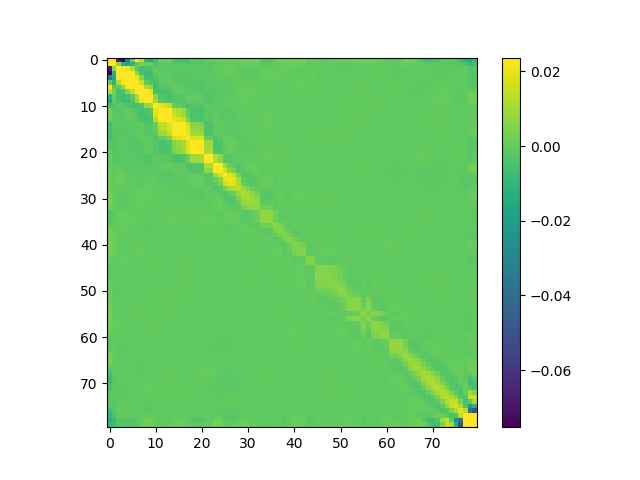

In [126]:
figure()
vmin, vmax = np.percentile(S2.numpy().ravel(),[0,99])
imshow(S2,vmin=vmin,vmax=vmax)
colorbar()

<IPython.core.display.Javascript object>


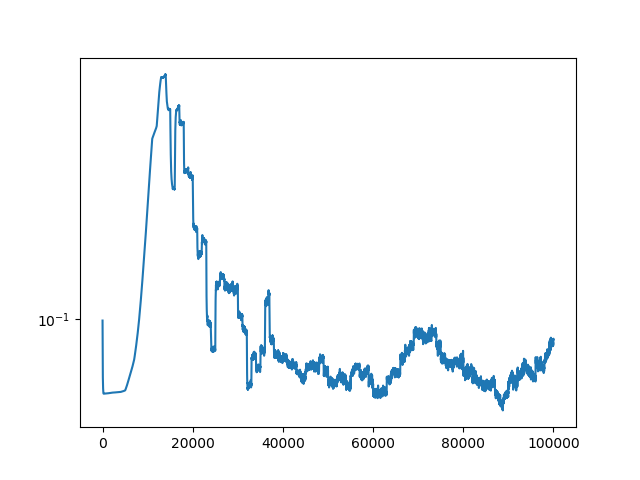

<IPython.core.display.Javascript object>


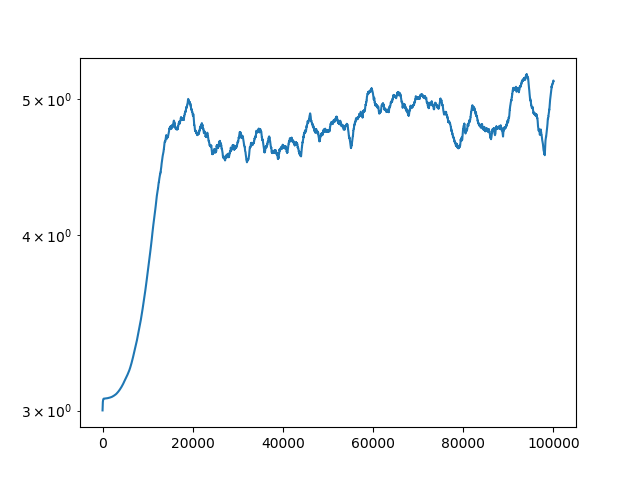

<IPython.core.display.Javascript object>


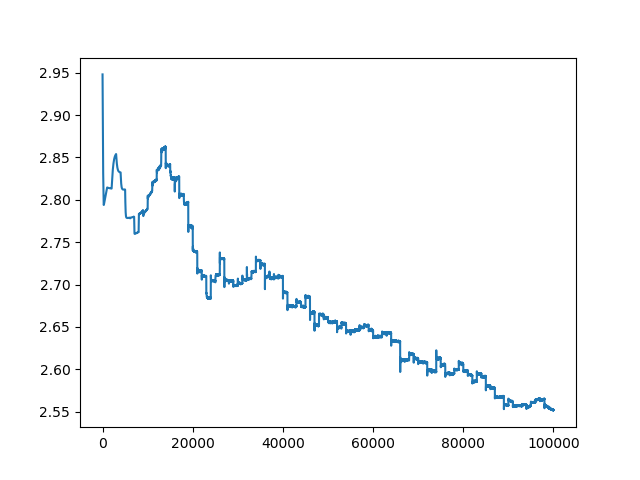

<IPython.core.display.Javascript object>


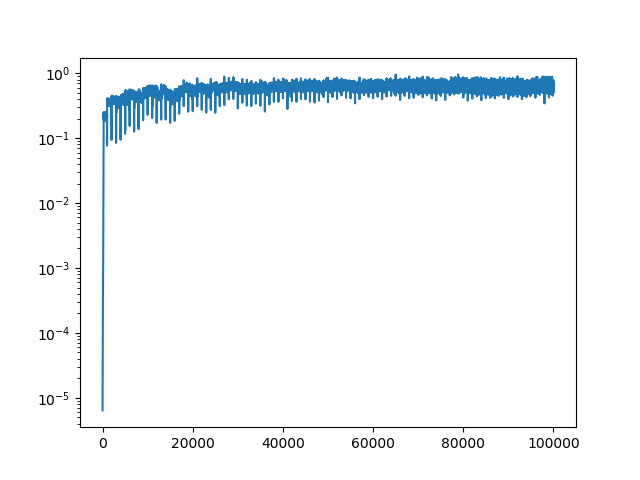

<IPython.core.display.Javascript object>


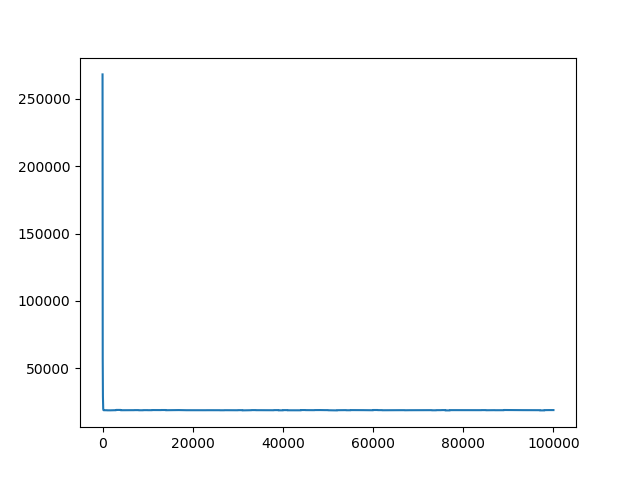

In [127]:
figure()
semilogy(Logger.val_dict['stored_modules.K0._lengthscale_storage'])
figure()
semilogy(Logger.val_dict['stored_modules.K0._amplitude_storage'])
figure()
plot(Logger.val_dict['stored_modules.mprior.value'])
figure()
semilogy(Logger.val_dict['step_size'])
figure()
plot(Logger.val_dict['loss'])

<IPython.core.display.Javascript object>


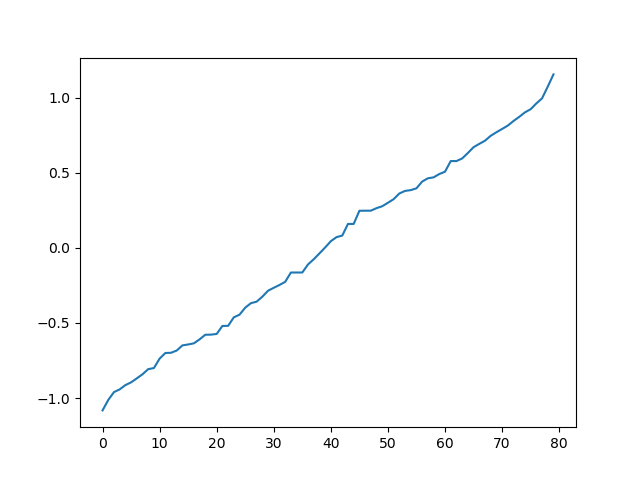

In [128]:
figure()
plot(np.sort(m.hyper_params['u0'].detach().numpy().squeeze()))

<IPython.core.display.Javascript object>


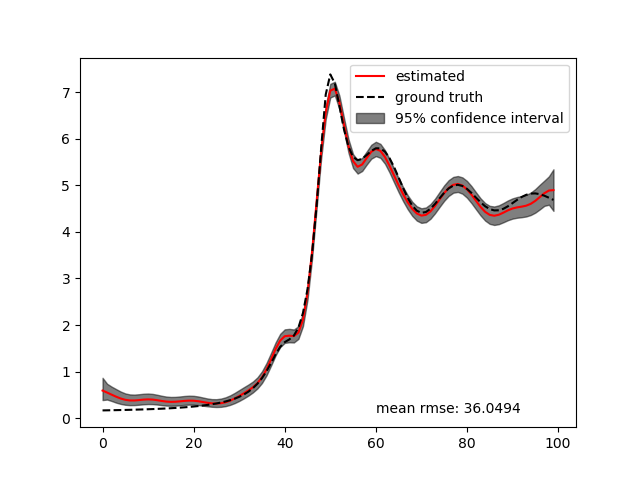

In [129]:
figure()
μvfe = m.predict_mean().detach().squeeze()
σvfe = m.predict_var().detach().sqrt().squeeze()
plot(torch.nn.functional.softplus(μvfe).numpy(), color='r', label='estimated')
fill_between(np.arange(100),torch.nn.functional.softplus(μvfe+1.96*σvfe).numpy(),torch.nn.functional.softplus(μvfe-1.96*σvfe).numpy(),color='k',alpha=0.5,label='95% confidence interval')
text(60, 0.1, f'mean rmse: {np.sqrt(np.sum((torch.nn.functional.softplus(μvfe).numpy()-np.squeeze(y)*np.sqrt(0.0225))**2)):.4f}')
plot(y*np.sqrt(10.),'k--',label='ground truth')
legend()
# savefig('1M-shots-poisson-nat-grad-HERFD-150k-photons-0.15-mean-rate.pdf')

In [56]:
ms = torch.cat([x.unsqueeze(1).cpu() for x in means],dim=1).numpy()
ss = torch.cat([x.unsqueeze(1).cpu() for x in stds],dim=1).numpy()

<IPython.core.display.Javascript object>


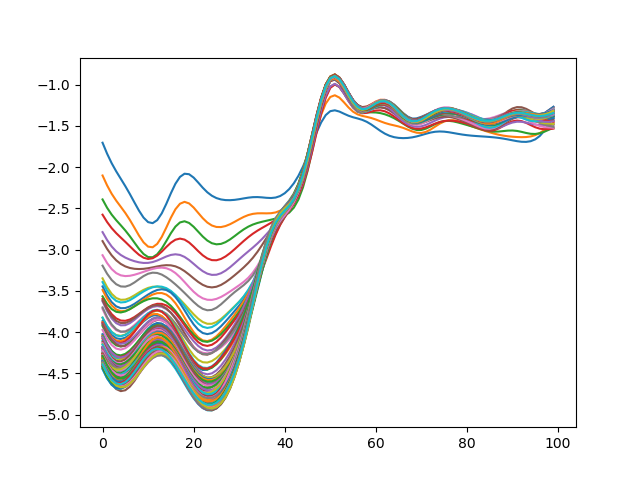

In [57]:
figure()
plot(ms[:,-200:])

<IPython.core.display.Javascript object>


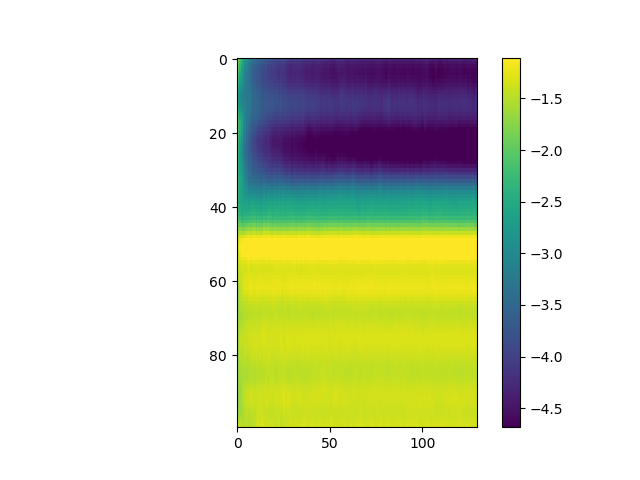

In [69]:
figure()
vmin, vmax = np.percentile(ms.ravel(),[5,95])
imshow(ms[:,:],vmin=vmin, vmax=vmax,aspect=2)
colorbar()
# savefig('100k-poisson-HERFD-natgrad-mean-evolution.png')

<IPython.core.display.Javascript object>


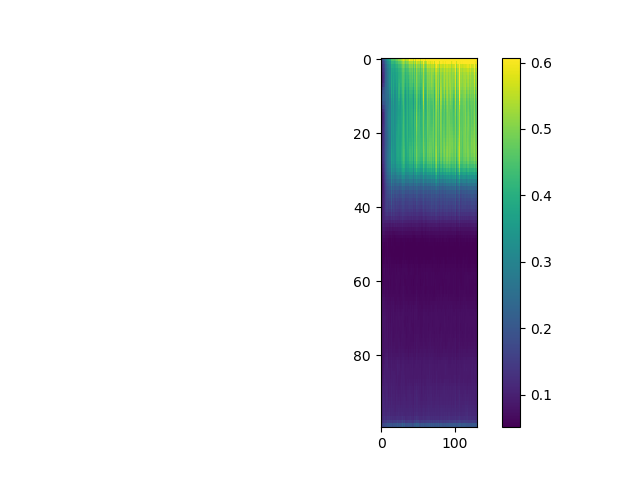

In [70]:
figure()
vmin, vmax = np.percentile(ss.ravel(),[1,99])
imshow(ss,vmin=vmin, vmax=vmax, aspect=5.0)
colorbar()
savefig('100k-poisson-HERFD-natgrad-std-evolution.png')

In [89]:
# m = VFE_1D_GPMM_Poisson(30,100,30000, Nmc=10);
# m.hyper_params['u'].requires_grad = False
# m.stored_modules['K0']._lengthscale_storage.requires_grad = False
# m.stored_modules['K0']._amplitude_storage.requires_grad = False
# m.stored_modules['mprior'].value.requires_grad = False
# m.cuda()
# hyper_optimizer = torch.optim.Adam(chain(m.hyper_params.parameters(), m.stored_modules.parameters()),lr=1e-2)
# optimizer = NaturalGradient(m.variational_gaussian.parameters(), lr=1)
# optimizer2 = torch.optim.Adam(m.variational_gaussian.parameters(), lr=1e-2)
# schedule = LogSpaceScheduler(optimizer, -5, -2, 100)
# bigbatcher = BigBatchScheduler(100000,100000,10,5)


epochs = 300
# scheduler = StepLR(optimizer,50,gamma=0.95)

# data = TensorDataset(torch.from_numpy(X.astype('float32')), torch.from_numpy(yc.astype('float32')))
# Logger = ScalarLogger(m, {'hyper_params.std_lik': m._makepos,
#                           'stored_modules.K0._lengthscale_storage': m._makepos,
#                           'stored_modules.K0._amplitude_storage': m._makepos,
#                           'stored_modules.mprior.value': lambda x: x},
#                      extra_keys={'loss': lambda x: x,
#                                 'step_size': lambda x: x})

for i in range(epochs):
#     bsize = bigbatcher.step()
#     print(bsize)
    d = DataLoader(dataset=data, shuffle=True, batch_size=30000)
    for (xb,yb) in d:
#         xbc, ybc = xb.cuda(), yb.cuda()
        optimizer.zero_grad()
#         optimizer2.zero_grad()
        hyper_optimizer.zero_grad()
        loss = m.loss(yb, xb)
        loss.backward()
        hyper_optimizer.step()
        schedule.step()
        optimizer.step(m.xi_to_source, m.source_to_xi)
#         optimizer2.step()
        Logger(extra_vals=[float(loss), float(optimizer.param_groups[0]['lr'])])
    print(Logger.report("epoch {:d}: ".format(i)))
        

epoch 0: hyper_params.std_lik: 0.5, stored_modules.K0._lengthscale_storage: 0.0481469, stored_modules.K0._amplitude_storage: 1.46642, stored_modules.mprior.value: 2.25916, loss: 63629, step_size: 1e-05, 
epoch 1: hyper_params.std_lik: 0.5, stored_modules.K0._lengthscale_storage: 0.0482217, stored_modules.K0._amplitude_storage: 1.46743, stored_modules.mprior.value: 2.27202, loss: 60652.8, step_size: 1.07227e-05, 
epoch 2: hyper_params.std_lik: 0.5, stored_modules.K0._lengthscale_storage: 0.0482909, stored_modules.K0._amplitude_storage: 1.46851, stored_modules.mprior.value: 2.28452, loss: 63098.1, step_size: 1.14976e-05, 
epoch 3: hyper_params.std_lik: 0.5, stored_modules.K0._lengthscale_storage: 0.048348, stored_modules.K0._amplitude_storage: 1.46971, stored_modules.mprior.value: 2.297, loss: 65120.2, step_size: 1.23285e-05, 
epoch 4: hyper_params.std_lik: 0.5, stored_modules.K0._lengthscale_storage: 0.0483502, stored_modules.K0._amplitude_storage: 1.47081, stored_modules.mprior.value: 

epoch 39: hyper_params.std_lik: 0.5, stored_modules.K0._lengthscale_storage: 0.0475938, stored_modules.K0._amplitude_storage: 1.49227, stored_modules.mprior.value: 2.55199, loss: 58724.3, step_size: 0.000151991, 
epoch 40: hyper_params.std_lik: 0.5, stored_modules.K0._lengthscale_storage: 0.0476179, stored_modules.K0._amplitude_storage: 1.49301, stored_modules.mprior.value: 2.55751, loss: 58875.5, step_size: 0.000162975, 
epoch 41: hyper_params.std_lik: 0.5, stored_modules.K0._lengthscale_storage: 0.0476486, stored_modules.K0._amplitude_storage: 1.49375, stored_modules.mprior.value: 2.5627, loss: 59152.4, step_size: 0.000174753, 
epoch 42: hyper_params.std_lik: 0.5, stored_modules.K0._lengthscale_storage: 0.0476453, stored_modules.K0._amplitude_storage: 1.49453, stored_modules.mprior.value: 2.56721, loss: 60187.4, step_size: 0.000187382, 
epoch 43: hyper_params.std_lik: 0.5, stored_modules.K0._lengthscale_storage: 0.0476242, stored_modules.K0._amplitude_storage: 1.49533, stored_modules

epoch 78: hyper_params.std_lik: 0.5, stored_modules.K0._lengthscale_storage: 0.0471934, stored_modules.K0._amplitude_storage: 1.51021, stored_modules.mprior.value: 2.65882, loss: 57578.6, step_size: 0.00231013, 
epoch 79: hyper_params.std_lik: 0.5, stored_modules.K0._lengthscale_storage: 0.0471971, stored_modules.K0._amplitude_storage: 1.51011, stored_modules.mprior.value: 2.65999, loss: 57828.2, step_size: 0.00247708, 
epoch 80: hyper_params.std_lik: 0.5, stored_modules.K0._lengthscale_storage: 0.0472, stored_modules.K0._amplitude_storage: 1.50996, stored_modules.mprior.value: 2.6611, loss: 57803.4, step_size: 0.00265609, 
epoch 81: hyper_params.std_lik: 0.5, stored_modules.K0._lengthscale_storage: 0.0472019, stored_modules.K0._amplitude_storage: 1.50986, stored_modules.mprior.value: 2.66196, loss: 57760.5, step_size: 0.00284804, 
epoch 82: hyper_params.std_lik: 0.5, stored_modules.K0._lengthscale_storage: 0.0472044, stored_modules.K0._amplitude_storage: 1.50973, stored_modules.mprior

RuntimeError: cholesky_cpu: U(4,4) is zero, singular U.